<a href="https://colab.research.google.com/github/robbianiandrea/focs/blob/main/Progetto_Andrea_Robbiani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

In [ ]:
sns.set(style="whitegrid")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("estratto")

csv_path = "estratto/dataset.csv"
df = pd.read_csv(csv_path, parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])

In [ ]:
# 1. Extract all trips with trip_distance larger than 50
long_trips = df[df["trip_distance"] > 50]

In [ ]:
# 2. Extract all trips where payment_type is missing
missing_payment = df[df["payment_type"].isna()]

In [ ]:
#3. For each (PULocationID, DOLocationID) pair, determine the number of trips
trip_counts = df.groupby(["PULocationID", "DOLocationID"]).size().reset_index(name="trip_count")
top_pairs = trip_counts.sort_values("trip_count", ascending=False).head(10)
top_pairs

,PULocationID,DOLocationID,trip_count
15793,237,236,6565
15597,236,237,5549
15596,236,236,5507
15794,237,237,4864
17878,264,264,3935
16110,239,238,2863
16051,239,142,2679
10513,161,237,2617
9027,142,239,2554
15738,237,162,2463


In [ ]:
#4. Save all rows with missing VendorID, passenger_count, store_and_fwd_flag, payment_type in a new dataframe called bad, and remove those rows from the original dataframe.
bad = df[df[["VendorID", "passenger_count", "store_and_fwd_flag", "payment_type"]].isna().any(axis=1)]
df = df.drop(bad.index)

In [ ]:
#5. Add a duration column storing how long each trip has taken (use tpep_pickup_datetime, tpep_dropoff_datetime)
df["duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60

In [ ]:
# Check if there are rows where tpep_pickup_datetime > tpep_dropoff_datetime, and if so, I remove them
df[df["tpep_pickup_datetime"] > df["tpep_dropoff_datetime"]]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration


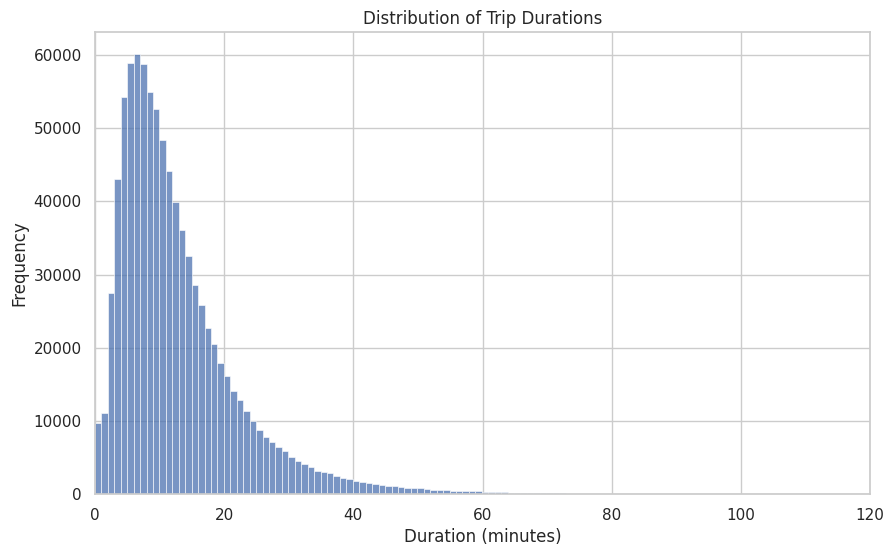

In [ ]:
# Visualization of the trip durations
plt.figure(figsize=(10, 6))
sns.histplot(df[df["duration"] <= 120]["duration"], bins=120)
plt.title("Distribution of Trip Durations")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.xlim(0, 120)
plt.show()

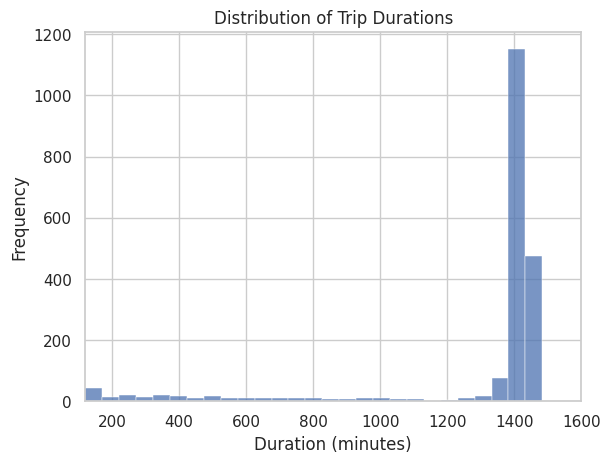

In [ ]:
# histogram for duration>120
sns.histplot(df[df["duration"] > 120]["duration"], bins=100)
plt.title("Distribution of Trip Durations")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.xlim(120, 1600)
plt.show()

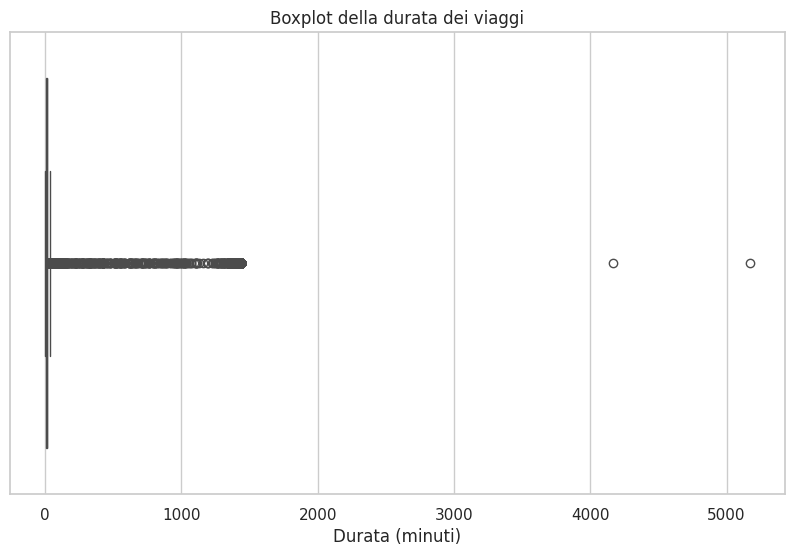

In [ ]:
#boxplot of trip duration (da capire se lasciare)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["duration"])
plt.title("Boxplot della durata dei viaggi")
plt.xlabel("Durata (minuti)")
plt.show()

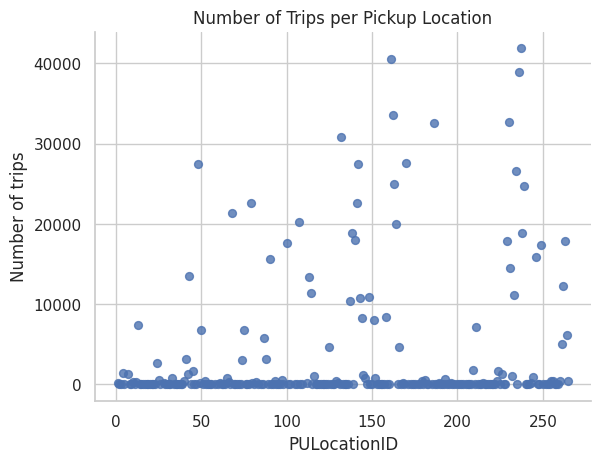

In [ ]:
#6 For each pickup location, determine how many trips have started there
pickup_counts = df["PULocationID"].value_counts().reset_index(name="trip_count").rename(columns={"index": "PULocationID"})
pickup_counts.plot(kind='scatter', x='PULocationID', y='trip_count', s=32, alpha=0.8)
plt.title("Number of Trips per Pickup Location")
plt.xlabel("PULocationID")
plt.ylabel("Number of trips")
plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

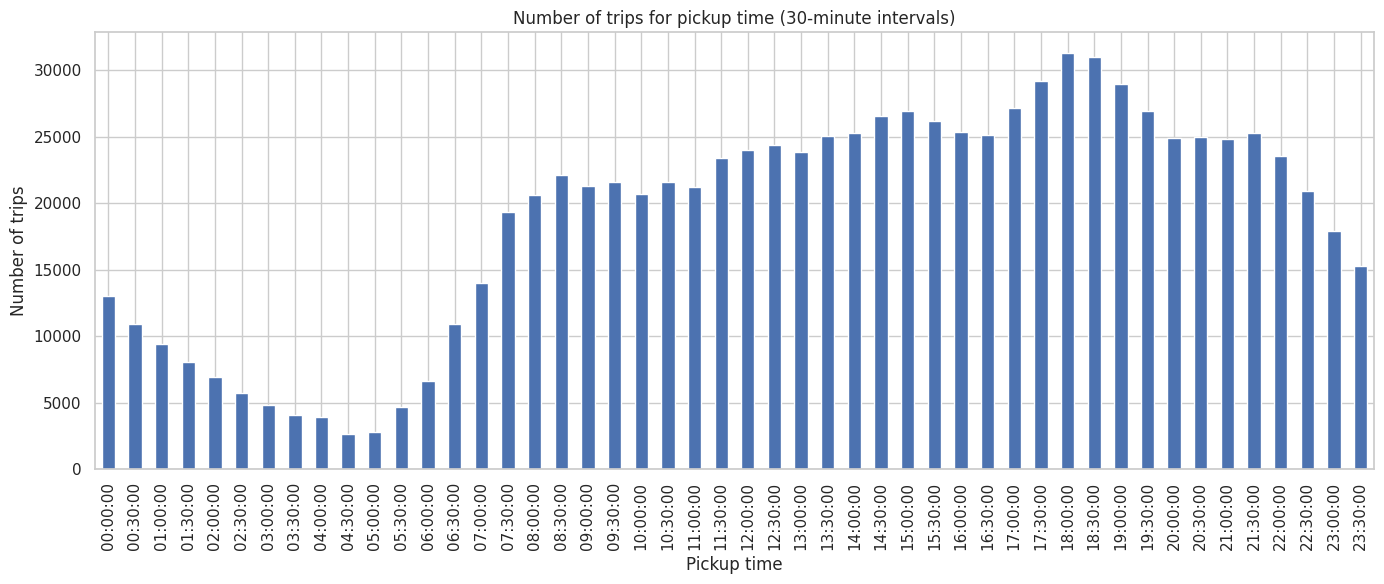

In [ ]:
# Step 7 - Cluster the pickup time of the day into 30-minute intervals
df["pickup_time_only"] = df["tpep_pickup_datetime"].dt.time
df["pickup_half_hour"] = df["tpep_pickup_datetime"].dt.floor("30min").dt.time
pickup_time_counts = df["pickup_half_hour"].value_counts().sort_index()
plt.figure(figsize=(14, 6))
pickup_time_counts.plot(kind="bar")
plt.title("Number of trips for pickup time (30-minute intervals)")
plt.xlabel("Pickup time")
plt.ylabel("Number of trips")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# 8. For each interval, determine the average number of passengers and the average fare amount
avg_passengers_fare = df.groupby("pickup_half_hour")[["passenger_count", "fare_amount"]].mean().reset_index()

In [ ]:
#1	Credit card
#2	Cash
#3	No charge
#4	Dispute

In [ ]:
# 9. For each payment type and each interval, determine the average fare amount
avg_fare_by_payment_interval = df.groupby(["payment_type", "pickup_half_hour"])["fare_amount"].mean().reset_index()
avg_fare_by_payment_interval

,payment_type,pickup_half_hour,fare_amount
0,1.0,00:00:00,13.898383
1,1.0,00:30:00,13.604947
2,1.0,01:00:00,13.170697
3,1.0,01:30:00,12.562116
4,1.0,02:00:00,12.253417
...,...,...,...
187,4.0,21:30:00,12.240385
188,4.0,22:00:00,2.693158
189,4.0,22:30:00,-8.672131
190,4.0,23:00:00,2.634615


In [ ]:
# 10. For each payment type, determine the interval when the average fare amount is maximum
max_fare_interval = avg_fare_by_payment_interval.loc[avg_fare_by_payment_interval.groupby("payment_type")["fare_amount"].idxmax()]
max_fare_interval

,payment_type,pickup_half_hour,fare_amount
10,1.0,05:00:00,21.350793
57,2.0,04:30:00,14.423238
105,3.0,04:30:00,12.870370
153,4.0,04:30:00,12.276190


In [ ]:
# 11. For each payment type, determine the interval when the overall ratio between the tip and the fare amounts is maximum
df["tip_ratio"] = df["tip_amount"] / df["fare_amount"]
df = df.replace([np.inf, -np.inf], np.nan)
valid_tip_ratio = df.dropna(subset=["tip_ratio"])
avg_tip_ratio = valid_tip_ratio.groupby(["payment_type", "pickup_half_hour"])["tip_ratio"].mean().reset_index()
max_tip_ratio = avg_tip_ratio.loc[avg_tip_ratio.groupby("payment_type")["tip_ratio"].idxmax()]
print(max_tip_ratio)


     payment_type pickup_half_hour  tip_ratio
3             1.0         01:30:00   1.943246
60            2.0         06:00:00   0.000187
113           3.0         08:30:00   0.033119
164           4.0         10:00:00   0.041353


In [ ]:
# 12. Find the location with the highest average fare amount
highest_avg_fare_loc = df.groupby("PULocationID")["fare_amount"].mean().idxmax()
print(f"Pickup location con la tariffa media più alta: {highest_avg_fare_loc}")

Pickup location con la tariffa media più alta: 180


In [ ]:
# 13. Build a new dataframe (called common) where, for each pickup location we keep all trips to the 5 most common destinations (i.e. each pickup location can have different common destinations)
top_dests = df.groupby(["PULocationID", "DOLocationID"]).size().reset_index(name="count")
top5 = top_dests.groupby("PULocationID").apply(lambda x: x.nlargest(5, "count")).reset_index(drop=True)
common = pd.merge(df, top5[["PULocationID", "DOLocationID"]], on=["PULocationID", "DOLocationID"])

<ipython-input-62-b2e77bf5f4a1>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5 = top_dests.groupby("PULocationID").apply(lambda x: x.nlargest(5, "count")).reset_index(drop=True)


In [ ]:
# 14. On the common dataframe, for each payment type and each interval, determine the average fare amount
common_avg = common.groupby(["payment_type", "pickup_half_hour"])["fare_amount"].mean().reset_index()

In [ ]:
# 15. Compute the difference of the average fare amount computed in the previous point with those computed at point 9.
# 16. Compute the ratio between the differences computed in the previous point and those computed in point 9.
fare_diff = pd.merge(
    avg_fare_by_payment_interval,
    common_avg,
    on=["payment_type", "pickup_half_hour"],
    suffixes=("_all", "_common"),
    how="left")
fare_diff["difference"] = fare_diff["fare_amount_common"] - fare_diff["fare_amount_all"]
fare_diff["ratio"] = fare_diff["difference"] / fare_diff["fare_amount_all"]
fare_diff

,payment_type,pickup_half_hour,fare_amount_all,fare_amount_common,difference,ratio
0,1.0,00:00:00,13.898383,8.532698,-5.365685,-0.386065
1,1.0,00:30:00,13.604947,8.877073,-4.727874,-0.347511
2,1.0,01:00:00,13.170697,9.069114,-4.101583,-0.311417
3,1.0,01:30:00,12.562116,8.277674,-4.284442,-0.341061
4,1.0,02:00:00,12.253417,7.495009,-4.758408,-0.388333
...,...,...,...,...,...,...
187,4.0,21:30:00,12.240385,28.425000,16.184615,1.322231
188,4.0,22:00:00,2.693158,3.921053,1.227895,0.455931
189,4.0,22:30:00,-8.672131,-9.312500,-0.640369,0.073842
190,4.0,23:00:00,2.634615,-4.400000,-7.034615,-2.670073


In [ ]:
# 17. Build chains of trips. Two trips are consecutive in a chain if (a) they have the same VendorID, (b) the pickup location of the second trip is also the dropoff location of the first trip,
#(c) the pickup time of the second trip is after the dropoff time of the first trip, and (d) the pickup time of the second trip is at most 2 minutes later than the dropoff time of the first trip.
sorted_df = df.sort_values(by=["VendorID", "tpep_pickup_datetime"])
sorted_df["prev_dropoff_time"] = sorted_df.groupby("VendorID")["tpep_dropoff_datetime"].shift()
sorted_df["prev_dropoff_loc"] = sorted_df.groupby("VendorID")["DOLocationID"].shift()
sorted_df["chain_start"] = (
    (sorted_df["PULocationID"] == sorted_df["prev_dropoff_loc"]) &
    (sorted_df["tpep_pickup_datetime"] > sorted_df["prev_dropoff_time"]) &
    ((sorted_df["tpep_pickup_datetime"] - sorted_df["prev_dropoff_time"]).dt.total_seconds() <= 120)
)
sorted_df["chain"] = sorted_df["chain_start"].cumsum()

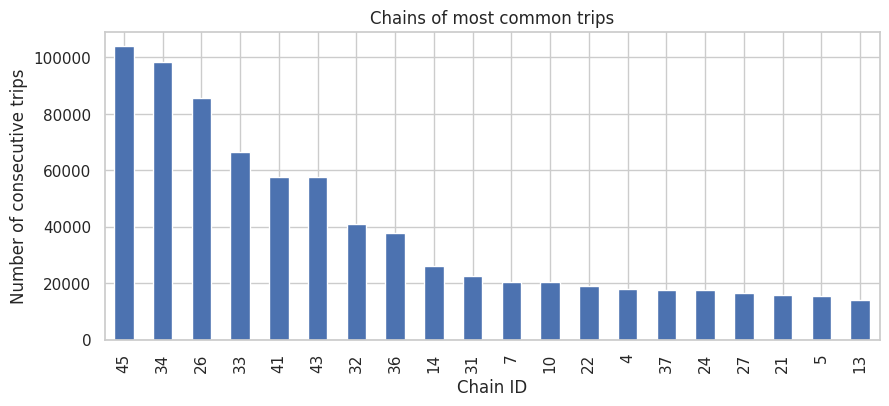

In [ ]:
plt.figure(figsize=(10, 4))
sorted_df["chain"].value_counts().head(20).plot(kind="bar")
plt.title("Chains of most common trips")
plt.xlabel("Chain ID")
plt.ylabel("Number of consecutive trips")
plt.show()